In [1]:
######################################################################
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. #
# SPDX-License-Identifier: MIT-0                                     #
######################################################################

import time
import json
import argparse
import numpy as np
import pandas as pd
from scipy import interpolate
import os
from tqdm import tqdm
import random
import datetime
# from datetime import datetime
import copy
import matplotlib.pyplot as plt
# import seaborn as sns
# from vehicle_data import vehicle_dict_ref, battery_dict

In [2]:
# Vehicle Characteristics
vehicle_dict_ref = {
    "unladen_wt_lbs": 10000,
    "scaler": {
        "cd": 1,
        "frontal_area": 1,
        "rolling_resistance": 1
    }
}

# Battery discharge characteristic from a Spec Speet
battery_dict = {
    'num_cells': 30000,
    'capacity': 12.16,
    'v': [4.75, 4.5, 4.4, 4.3, 4.2, 4.1, 4.05, 4.0, 3.8, 3.7, 2.0],
    'D_Wh': [0, 0.4, 1.0, 2.0, 3.0, 4.0, 4.2, 4.6, 4.7, 4.8, 5.0]
}

In [3]:
def calc_degradation(cum_trip_dist, cum_trip_hours, cum_load):
    """
    Enforce a degradation in the sample dataset
    :param cum_trip_dist: Cumulative Distance Travelled
    :param cum_trip_hours: Cumulative Trip Hours Logged
    :param cum_load: Cumulative Load carried by the vehicle
    :return:
    """
    nTripFactor = 10
    distFactor = 200  # Used in distance distribution
    tripTimeFactor = 4.0  # Used in trip time distribution
    loadFactor = 10000
    ret_deg_factor = \
        (np.power((1 + 0.35), cum_trip_dist / (nTripFactor * distFactor)) - 1.) + \
        (np.power((1 + 0.35), cum_trip_hours / (nTripFactor * tripTimeFactor)) - 1.) + \
        (np.power((1 + 0.35), cum_load / (nTripFactor * loadFactor)) - 1.)

    return ret_deg_factor * 0.01


def gen_single_route(trip_len_miles, trip_duration_hrs, trip_load_lb, vehicle_dict, delta_len_miles=0.1):
    """

    Calculate the Kwh usage along the trip

    :param trip_len_miles: Length of the Trip in miles
    :param trip_duration_hrs: Duration of Trip in Hours
    :param trip_load_lb: Loaded vehicle weight
    :param vehicle_dict: Vehicle specific inputs
    :param delta_len_miles: Export simulation data for this length discretization
    :return:
    """
    trip_avg_speed = trip_len_miles / trip_duration_hrs

    avg_kwh_mile = 50. / 80.  # 80 miles in 50 KWh
    drag_force_fraction = 0.3  # 30% of propulsive brake power
    rolling_resistance_fraction = 0.1  # 10% of propulsive brake power
    load_fraction = 0.2  # 20% of the brake power

    kwh_mile = avg_kwh_mile * (1 + \
                               drag_force_fraction * (1.0 - vehicle_dict['scaler']['cd']) + \
                               drag_force_fraction * (trip_avg_speed / 60.0) ** 2 + \
                               rolling_resistance_fraction * (1 - vehicle_dict['scaler']['rolling_resistance']) + \
                               load_fraction * (trip_load_lb / vehicle_dict['unladen_wt_lbs'])
                               )

    # Sample at delta_len Miles
    trip_dist_1d = np.arange(0, 0.9 * trip_len_miles, delta_len_miles)

    # Get higher density points (10X) during last 10% of trip to model the steep discharge
    trip_dist_1d = np.append(trip_dist_1d, np.arange(0.9 * trip_len_miles, trip_len_miles, 0.1 * delta_len_miles))

    kwh_1d = kwh_mile * trip_dist_1d
    time_1d = trip_dist_1d / trip_avg_speed

    ret_pd = pd.DataFrame()
    ret_pd['trip_time'] = time_1d
    ret_pd['trip_kwh'] = kwh_1d
    ret_pd['trip_dist'] = trip_dist_1d
    return ret_pd


def add_v_battery(trip_pd, battery_dict, degradation=0.):
    """

    For a given route and kwh consumption
    Convert the requirement to a per-cell basis and generate the voltage characteristic

    :param trip_pd: Pandas dataframe to be augmented with Cell Characteristics
    :param battery_dict: Battery Discharge curve specification
    :param degradation: Enforce a degradation to simulate depleted full battery capacity
    :return: Populated DataFrame
    """
    trip_kwh = trip_pd['trip_kwh'].values
    trip_battery_peak_capacity = battery_dict['num_cells'] * battery_dict['capacity']
    trip_battery_degraded_capacity = (1 - degradation) * trip_battery_peak_capacity
    trip_soc = (trip_battery_degraded_capacity - trip_kwh * 1000) / trip_battery_peak_capacity

    trip_kwh_cell = trip_kwh * 1000. / (battery_dict['num_cells'])
    f = interpolate.interp1d(np.array(battery_dict['D_Wh']) * (1 - degradation),
                             np.array(battery_dict['v']) * (1 - degradation),
                             kind='slinear',
                             bounds_error=False,
                             fill_value=np.nan)
    v = f(trip_kwh_cell)
    trip_pd['trip_v'] = v
    trip_pd['soc'] = trip_soc
    return trip_pd

def generate_data(analyticSettings, pm_root_path):

    n_vehicles = analyticSettings['n_vehicles']
    n_routes = analyticSettings['n_routes']
    rel_dest_path = analyticSettings['rel_dest_path']

    data_path_full = '%s/%s'%(pm_root_path, rel_dest_path)

    work_dir = data_path_full
    plots_dir = '%s/plots'%(work_dir)
    genPlot = True
    os.makedirs(work_dir, exist_ok=True)
    os.makedirs(plots_dir, exist_ok=True)

    route_pd_list = []

    out_trip_pd_fname = work_dir + '/trip_pd.csv'
    fid = open(out_trip_pd_fname, 'w')
    fid.write('vin,route,degradation,trip_dist,trip_duration,trip_load,cum_dist,cum_duration,cum_load\n')

    cum_trip_dist = np.zeros(n_vehicles)
    cum_trip_duration = np.zeros(n_vehicles)
    cum_trip_load = np.zeros(n_vehicles)
    for i_vehicle in tqdm(range(n_vehicles)):
        datetime_base = datetime.datetime(2020, 1, 1)
        for i_route in (range(n_routes)):
            # Normal distribution with mean of 200, std dev of 20 miles
            cur_trip_dist = np.random.normal(loc=200, scale=20)
            # Enforce Clipping Bounds (with Trip > 50 miles)
            while cur_trip_dist <= 50:
                cur_trip_dist = np.random.normal(loc=200, scale=20)

            # Normal Distribution of 5 and std dev of 0.5
            cur_trip_duration = np.random.normal(loc=5, scale=0.5)
            # Enforce clipping bounds trim duration to be > 1.0
            while cur_trip_duration <= 1.0:
                cur_trip_duration = np.random.normal(loc=5, scale=0.5)
            # Trip Load normally distributed around mean 10000 and std dev of 1000
            cur_trip_load = np.random.normal(loc=10000, scale=1000)
            # Clip non physical loads
            while cur_trip_load <= 0:
                cur_trip_load = np.random.normal(loc=10000, scale=1000)

            add_pd = gen_single_route(cur_trip_dist, cur_trip_duration, cur_trip_load, vehicle_dict_ref,
                                      delta_len_miles=1.0)

            # Implement the logic of degradation following a trend
            cur_trip_degradation = calc_degradation(cum_trip_dist[i_vehicle],
                                                    cum_trip_duration[i_vehicle],
                                                    cum_trip_load[i_vehicle])

            degradation_set = cur_trip_degradation

            add_pd = add_v_battery(add_pd, battery_dict, degradation=degradation_set)
            add_pd['route'] = i_route
            add_pd['vin'] = 'V' + str(i_vehicle)
            add_pd['datetime'] = datetime_base + (24 * i_route + add_pd['trip_time']) * datetime.timedelta(hours=1)
            add_pd['cum_trip_dist'] = cum_trip_dist[i_vehicle] + add_pd['trip_dist'].values

            # Taking a max because the trip can be pruned if battery cannot meet request!!
            cum_trip_dist[i_vehicle] += np.max(add_pd['trip_dist'].values)
            cum_trip_duration[i_vehicle] += np.max(add_pd['trip_time'].values)
            cum_trip_load[i_vehicle] += cur_trip_load

            route_pd_list.append(add_pd)
            fid.write('V%d,%d,%8.7e,%f,%f,%f,%f,%f,%f\n' % (
            i_vehicle, i_route, degradation_set, cur_trip_dist, cur_trip_duration, cur_trip_load,
            cum_trip_dist[i_vehicle], cum_trip_duration[i_vehicle], cum_trip_load[i_vehicle]))

    fid.close()
    overall_pd = pd.concat(route_pd_list)
    overall_pd = overall_pd.dropna()
    print('Shape of Overall Pandas DataFrame: %s'%(str(overall_pd.shape)))
    out_overall_pd_fname = work_dir + '/overall_pd.csv'

    overall_pd.to_csv(out_overall_pd_fname)

    grouped_pd = overall_pd.groupby(by=['vin'])

    if genPlot:
        fig, ax = plt.subplots(4, 1, figsize=(10, 4), sharex=True)
        for key, grp in grouped_pd:
            # x_axis_column = 'trip_time'
            x_axis_column = 'datetime'
            ax[0].plot(grp[x_axis_column], grp['soc'], label=key, linestyle='--', marker='.')
            ax[1].plot(grp[x_axis_column], grp['trip_v'], label=key, linestyle='--', marker='.')
            ax[2].plot(grp[x_axis_column], grp['trip_dist'], label=key, linestyle='--', marker='.')
            ax[3].plot(grp[x_axis_column], grp['cum_trip_dist'], label=key, linestyle='--', marker='.')
        ax[0].set_ylabel('Trip SOC')
        ax[1].set_ylabel('Trip V')
        ax[-1].set_ylabel('Trip Distance')
        ax[-1].set_xlabel('Time (Hrs)')
        ax[0].grid()
        ax[1].grid()
        ax[-1].grid()
        ax[0].legend()
        fig.savefig(plots_dir + '/SOC_V_Dist.png')
        fig2 = plt.figure(2)
        for key, grp in grouped_pd:
            plt.plot(grp['cum_trip_dist'], grp['trip_v'], linestyle='--', marker='.')
        plt.grid()
        plt.xlabel('Cumulative Trip Distance (mi)')
        plt.ylabel('Trip Voltage (V)')
        fig2.savefig(plots_dir + '/cumDist.png')

def export_status(analyticSettings, pm_root_path):
    # Export a model_details with successful state
    rel_dest_path = analyticSettings['rel_dest_path']
    data_path_full = '%s/%s'%(pm_root_path, rel_dest_path)
    timestr = datetime.now().strftime("%Y%m%d-%H%M%S-%f")
    status_path_full = '%s_status.json'%(os.path.splitext(data_path_full))

    with open(status_path_full, 'w') as fp:
        status_dict = {
            'timestamp': timestr,
            'status': 0,
            'output': rel_dest_path
        }
        json.dump(status_dict, fp)
        print('Task status: %s'%(status_path_full))


# if __name__ == '__main__':
    # pm_root_path = os.getenv('PM_ROOT_PATH')
    
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--task-json-path', help='Relative path to the json file describing this data generation task')
    # args = parser.parse_args()

    # task_json_path_full = '%s/%s'%(pm_root_path, args.task_json_path)
    # with open(task_json_path_full, 'r') as fp:
    #     task_dict = json.load(fp)
    #     generate_data(analyticSettings=task_dict['analyticSettings'],
    #                   pm_root_path=pm_root_path)

    #     export_status(analyticSettings=task_dict['analyticSettings'],
    #                   pm_root_path=pm_root_path)
        


In [4]:
pm_root_path = '.'
rel_data_path = 'data'

# parser = argparse.ArgumentParser()
# parser.add_argument('--task-json-path', help='Relative path to the json file describing this data generation task')
# args = parser.parse_args()
task_dict = {
"analyticSettings": {
    "n_vehicles": 100,
    "n_routes": 100,
    "rel_dest_path": rel_data_path}}

if os.path.exists(os.path.join(pm_root_path, rel_data_path)):
    print('Data exists')
else:
    generate_data(analyticSettings=task_dict['analyticSettings'],
                    pm_root_path=pm_root_path)

# # export_status(analyticSettings=task_dict['analyticSettings'],
# #                 pm_root_path=pm_root_path)


In [5]:
df = pd.read_csv('./data/trip_pd.csv')
print(df.keys())
print(df.shape)
# print(df['vin'].value_counts())
df['trip_velocity'] = df['trip_dist'] / df['trip_duration']

print(df.head())
print(df.shape)

Index(['vin', 'route', 'degradation', 'trip_dist', 'trip_duration',
       'trip_load', 'cum_dist', 'cum_duration', 'cum_load'],
      dtype='object')
(10000, 9)
  vin  route  degradation   trip_dist  trip_duration     trip_load   
0  V0      0     0.000000  208.681654       4.916049   8492.692945  \
1  V0      1     0.000952  181.907431       3.901482  12101.258271   
2  V0      2     0.001925  207.141648       5.668530  10505.511407   
3  V0      3     0.003064  183.274509       5.435936  10345.173046   
4  V0      4     0.004179  203.075264       4.352323   9258.919371   

     cum_dist  cum_duration      cum_load  trip_velocity  
0  208.613489      4.914443   8492.692945      42.449059  
1  390.430177      8.813979  20593.951216      46.625213  
2  597.557660     14.482122  31099.462623      36.542392  
3  780.804719     19.917243  41444.635669      33.715354  
4  983.872456     24.269404  50703.555040      46.659052  
(10000, 10)


In [6]:
x = df.loc[(df['vin'] == 'V0') & (df['route'] == 0)]
print(x['trip_velocity'].item())
print(np.array(x['trip_velocity'].item(), dtype=np.float32))

42.44905899025824
42.44906


In [7]:
df = pd.read_csv('./data/trip_pd.csv')
print(df.keys())
print(df.shape)
# print(df['vin'].value_counts())
print(df.head())

Index(['vin', 'route', 'degradation', 'trip_dist', 'trip_duration',
       'trip_load', 'cum_dist', 'cum_duration', 'cum_load'],
      dtype='object')
(10000, 9)
  vin  route  degradation   trip_dist  trip_duration     trip_load   
0  V0      0     0.000000  208.681654       4.916049   8492.692945  \
1  V0      1     0.000952  181.907431       3.901482  12101.258271   
2  V0      2     0.001925  207.141648       5.668530  10505.511407   
3  V0      3     0.003064  183.274509       5.435936  10345.173046   
4  V0      4     0.004179  203.075264       4.352323   9258.919371   

     cum_dist  cum_duration      cum_load  
0  208.613489      4.914443   8492.692945  
1  390.430177      8.813979  20593.951216  
2  597.557660     14.482122  31099.462623  
3  780.804719     19.917243  41444.635669  
4  983.872456     24.269404  50703.555040  


In [8]:
df = pd.read_csv('./data/overall_pd.csv')
print(df.keys())
print(df.shape)

v_nums = [0, 1, 2, 3]
v_nums = ['V' + str(i) for i in v_nums]
print(v_nums)

sample = df.loc[(df['vin'].isin(v_nums))]
print(sample.shape)

Index(['Unnamed: 0', 'trip_time', 'trip_kwh', 'trip_dist', 'trip_v', 'soc',
       'route', 'vin', 'datetime', 'cum_trip_dist'],
      dtype='object')
(1608302, 10)
['V0', 'V1', 'V2', 'V3']
(64374, 10)


In [12]:
df['trip_dist'].max()

192.6698463096132

In [9]:
sample_route = sample.loc[(sample['route'] == 0)]
print(sample_route.shape)

(856, 10)


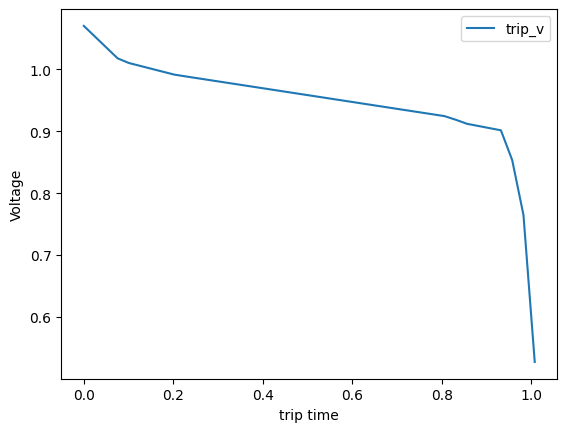

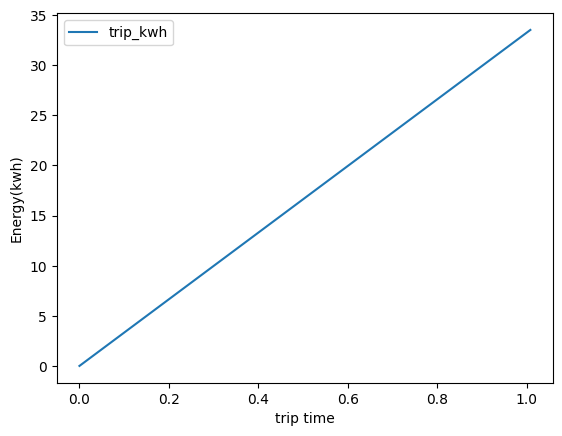

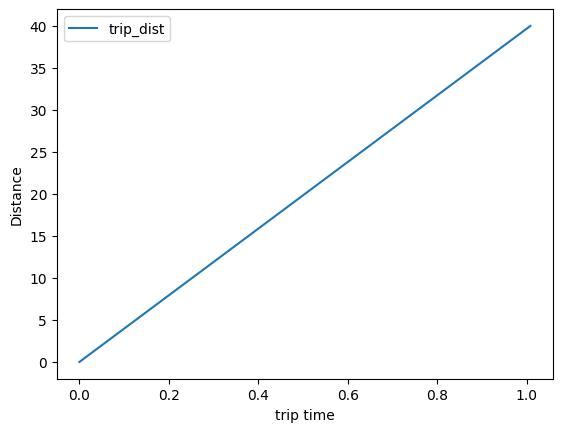

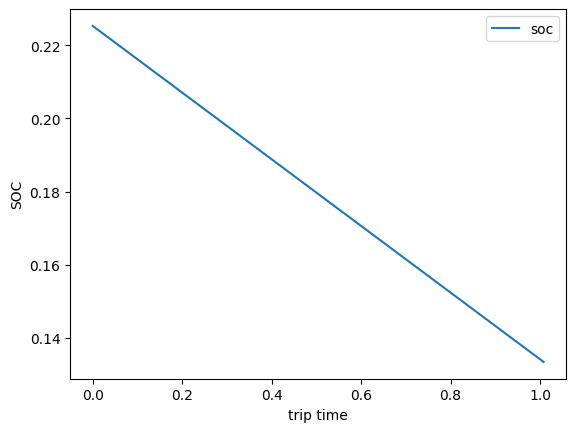

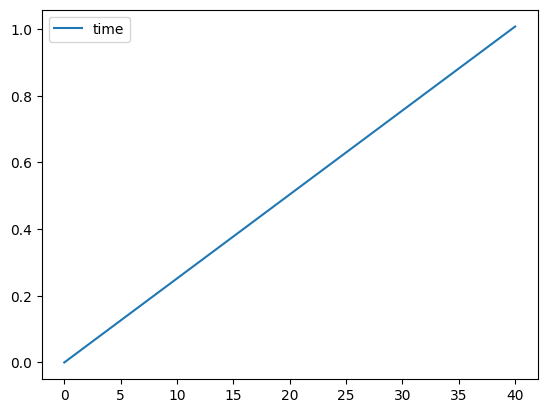

In [32]:
sample_route = sample.loc[(sample['route'] == 99)]

plt.plot(sample_route['trip_time'], sample_route['trip_v'], label = 'trip_v')
plt.legend()
plt.xlabel('trip time')
plt.ylabel('Voltage')
plt.show()

plt.plot(sample_route['trip_time'], sample_route['trip_kwh'], label = 'trip_kwh')
plt.legend()
plt.xlabel('trip time')
plt.ylabel('Energy(kwh)')
plt.show()

plt.plot(sample_route['trip_time'], sample_route['trip_dist'], label = 'trip_dist')
plt.legend()
plt.xlabel('trip time')
plt.ylabel('Distance')
plt.show()

plt.plot(sample_route['trip_time'], sample_route['soc'], label = 'soc')
plt.legend()
plt.xlabel('trip time')
plt.ylabel('SOC')
plt.show()

plt.plot(range(sample_route.shape[0]), sample_route['trip_time'], label = 'time')
plt.legend()
plt.show()

todo : trip velocity 추가해서 입력값으로 사용